In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

## 0. Выберите любой датасет, связанный с медицинской тематикой.

# 1. Провести EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных вцелом

In [2]:
survey = pd.read_csv('survey.csv')
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
df = survey.drop([
    'Timestamp', 'comments',
    'Country', 'state',
], axis=1)

for i, column in enumerate(df.columns):
    if df.dtypes[i] == 'object':
        display(column, df[column].value_counts())
    else:
        display(column, df[column].describe())

'Age'

count          1259.00
mean       79428148.31
std      2818299442.98
min           -1726.00
25%              27.00
50%              31.00
75%              36.00
max     99999999999.00
Name: Age, dtype: float64

'Gender'

Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Woman                                               3
Male                                                3
Female                                              2
Female (trans)                                      2
Cis Male                                            2
Man                                                 2
woman                                               1
Agender                                             1
Cis Man                                             1
Male-ish                    

'self_employed'

No     1095
Yes     146
Name: self_employed, dtype: int64

'family_history'

No     767
Yes    492
Name: family_history, dtype: int64

'treatment'

Yes    637
No     622
Name: treatment, dtype: int64

'work_interfere'

Sometimes    465
Never        213
Rarely       173
Often        144
Name: work_interfere, dtype: int64

'no_employees'

6-25              290
26-100            289
More than 1000    282
100-500           176
1-5               162
500-1000           60
Name: no_employees, dtype: int64

'remote_work'

No     883
Yes    376
Name: remote_work, dtype: int64

'tech_company'

Yes    1031
No      228
Name: tech_company, dtype: int64

'benefits'

Yes           477
Don't know    408
No            374
Name: benefits, dtype: int64

'care_options'

No          501
Yes         444
Not sure    314
Name: care_options, dtype: int64

'wellness_program'

No            842
Yes           229
Don't know    188
Name: wellness_program, dtype: int64

'seek_help'

No            646
Don't know    363
Yes           250
Name: seek_help, dtype: int64

'anonymity'

Don't know    819
Yes           375
No             65
Name: anonymity, dtype: int64

'leave'

Don't know            563
Somewhat easy         266
Very easy             206
Somewhat difficult    126
Very difficult         98
Name: leave, dtype: int64

'mental_health_consequence'

No       490
Maybe    477
Yes      292
Name: mental_health_consequence, dtype: int64

'phys_health_consequence'

No       925
Maybe    273
Yes       61
Name: phys_health_consequence, dtype: int64

'coworkers'

Some of them    774
No              260
Yes             225
Name: coworkers, dtype: int64

'supervisor'

Yes             516
No              393
Some of them    350
Name: supervisor, dtype: int64

'mental_health_interview'

No       1008
Maybe     207
Yes        44
Name: mental_health_interview, dtype: int64

'phys_health_interview'

Maybe    557
No       500
Yes      202
Name: phys_health_interview, dtype: int64

'mental_vs_physical'

Don't know    576
Yes           343
No            340
Name: mental_vs_physical, dtype: int64

'obs_consequence'

No     1075
Yes     184
Name: obs_consequence, dtype: int64

# 2. Спланировать эксперимент 

Эксперимент - составить план, по которому будет проделана исследовательская работа. Примерные пункты плана:
* Составить первичный список признаков, необходимых для решения задачи
* Нормализовать выбранные признаки
* Сгенерировать список новых признаков, которые можно получить из данных
* Применить понижение размерности для визуализации данных
* Применить кластеризацию, визуализировать
* Описание кластера

В качестве темы выбрана связь между факторами зависящими от респондента и его семьи и полом и возрастом. 

Отобраны следующие признаки:
* Age - возраст
* Gender - половая принадлежность
* treatment - Факт наличия случая обращения за врачебной помощью
* family_history - Факт наличия случаев заболения у семьи
* work_interfere - Степень влияние на работу

В возрасте имются выбросы которые необходимо отсечь.
Половоя принадлежность должна быть приведена к большему единообразию

Часть признаков являются категориальными поэтому требуется формирование производных признаков на их основе при помощи One Hot кодивания.

Выбрано снижение размерности до двух признаков.

Кластеризация должна быть выполнения при помощи DBScan.

Скопления должны быть изучены на предмет характерных черт.

# 3. Выполнить подготовку данных для построения модели

Выполнить необходимые преобразования данных

In [4]:
features = [
       'Gender', 'Age',
       'self_employed', 
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence',    
]

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

df['Gender'] = df['Gender'].map(lambda gender: {
    'm': 'male', 'male': 'male', 'man': 'male',
    'f': 'male', 'female': 'female', 'woman': 'female',
}.get(gender.lower(), 'other'))
df['Gender'] = pd.Categorical(df['Gender'])
for feature in ['self_employed']:
    if feature not in df.columns:
        continue
    df[feature] = SimpleImputer(strategy='most_frequent').fit_transform(pd.DataFrame({feature: df[feature]}))
df = df[df['Age'].between(0, 153)]

df = df.loc[:, features].dropna()

from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

categorial_features = [feature for feature in df.columns if feature not in ['Age']]
categorial_features_indices = [i for i, col in enumerate(features) if col in categorial_features]
not_categorial_features_indices = [i for i, col in enumerate(features) if col not in categorial_features]
encoder = ColumnTransformer([
    ('enc_non_cat', IdentityTransformer(), not_categorial_features_indices),
    ('enc_cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorial_features_indices),
])

pipeline_for_explained_variance_ratio_ = Pipeline(steps = [
    ('encoder', encoder),
    ('scaler', StandardScaler()),
    ('pca', PCA()),
])

pipeline_for_explained_variance_ratio_.fit(df)

pipeline_for_clusterization = Pipeline(steps = [
    ('encoder', encoder),
    ('scaler', StandardScaler()),
])

X_prepared = pipeline_for_clusterization.fit_transform(df)

pipeline_for_visualization = Pipeline(steps = [
    ('encoder', encoder),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

X_reduced = pipeline_for_visualization.fit_transform(df)

Построим график вклада различных компонент в общую вариативность

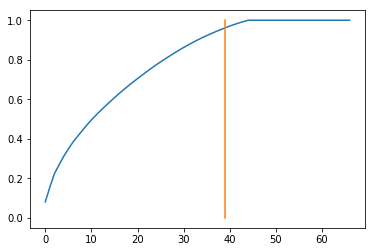

In [6]:
cumsum = np.cumsum(pipeline_for_explained_variance_ratio_.steps[2][1].explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)
plt.plot([d, d], [0, 1])

Как можно видеть по графику компонент с преобладающим влиянием не выделяется

# 4. Провести построение модели 

Для определения параметров кластеризации построим график зависимости количество кластеров от максимального растояния и минимального количества образцов 

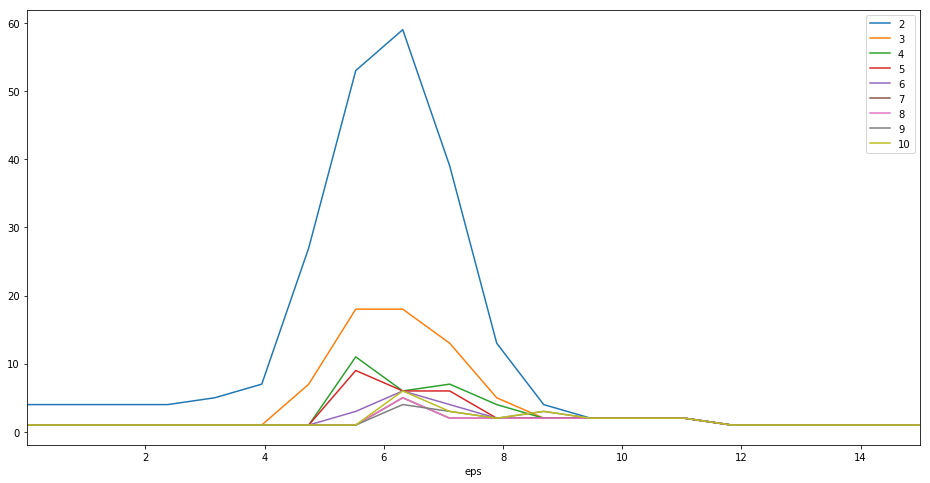

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.metrics.scorer import make_scorer
import matplotlib.lines as mlines
from itertools import product

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

eps_values = np.linspace(0.01, 14.99, 20)
min_samples_values = range(2, 11, 1)

parameters = pd.DataFrame(columns = ['eps', 'min_samples', 'count', ])

counts = []

for i, (eps, min_samples) in enumerate(product(eps_values, min_samples_values)):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_prepared)
    cnt = len(set(dbscan.labels_))
    counts.append(cnt) 

    parameters.loc[i] = [
        eps, 
        min_samples, 
        len(set(dbscan.labels_)), 
    ]      

for min_samples in min_samples_values:
    parameters[parameters['min_samples'] == min_samples].plot(x='eps', y='count', label=f'{min_samples}', ax=ax)
plt.legend()

Воспользовавшись критерием локтя выбираем параметры по точке на пологом участке спуска наиболее пологово графика

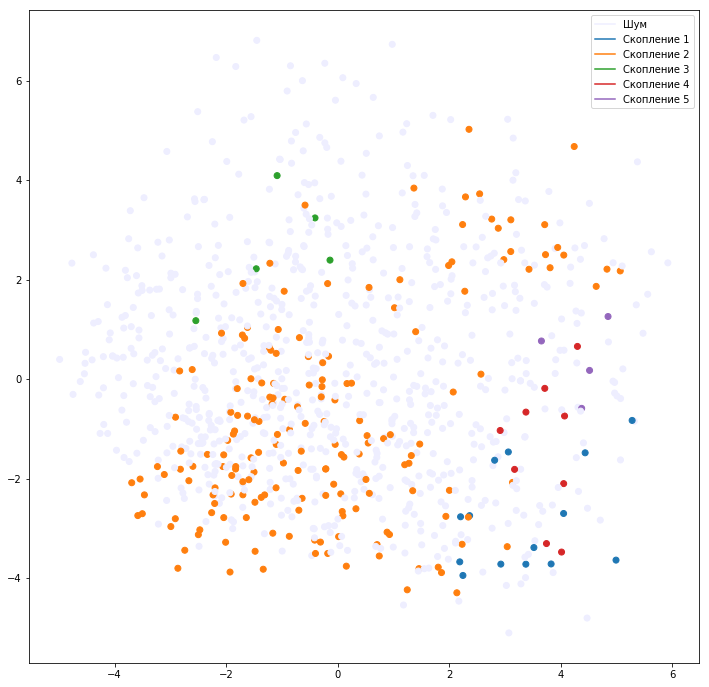

In [8]:
import matplotlib.lines as mlines

target_eps = 6.3
target_min_samples = 5

dbscan = DBSCAN(eps=target_eps, min_samples=target_min_samples).fit(X_prepared)
clusters = dbscan.labels_

clustered = df.copy()

clustered['first'] = X_reduced[:, 0]
clustered['second'] = X_reduced[:, 1]
clustered['cluster'] = clusters
clustered['count'] = 1

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors_cycle = prop_cycle.by_key()['color']
colors_map = {cluster: colors_cycle[cluster % len(colors_cycle)] for cluster in clustered['cluster']}
colors_map[-1] = '#EEEEFF'
colors = [colors_map[cluster] for cluster in clustered['cluster']]

artists = ax.scatter(clustered['first'], clustered['second'], c=colors)
clusters = clustered['cluster'].unique()
handles = [
    mlines.Line2D([], [], color=colors_map[cluster], label=(f'Скопление {cluster + 1}' if cluster != -1 else 'Шум'))
    for cluster in sorted(clusters)
]
plt.legend(handles=handles)

# 5. Проанализировать результат
получилось или нет, почему, что можно улучшить, можно ли интерпретировать результат

Text(0.5, 0, 'Скопление')

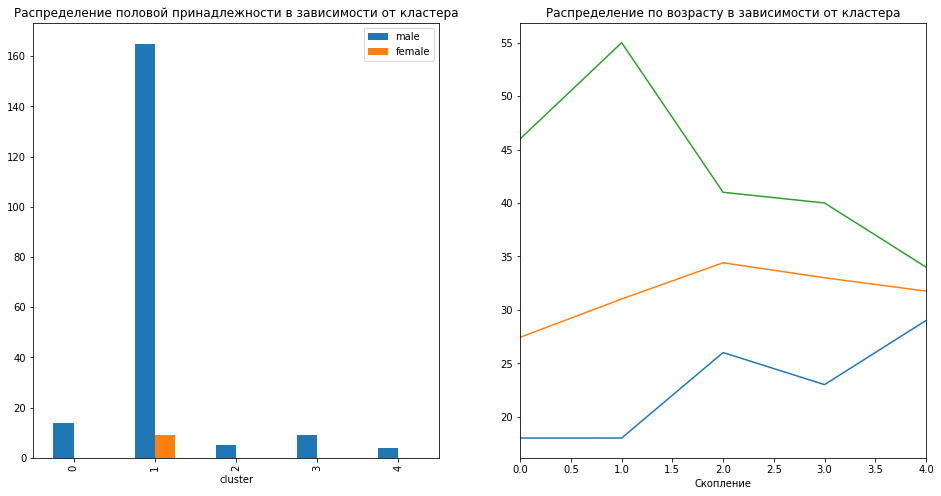

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

clustered = clustered[clustered['cluster'] != -1]

gendered = clustered
gendered['count'] = 1
genders = pd.DataFrame({
    gender: gendered[gendered['Gender'] == gender]['count'] 
    for gender in gendered['Gender'].unique()
}).fillna(0)
genders['cluster'] = gendered['cluster']
genders.groupby(['cluster']).sum().plot.bar(ax=ax[0])
ax[0].set_title('Распределение половой принадлежности в зависимости от кластера')
plt.xlabel('Скопление')

clustered.groupby(['cluster']).min()['Age'].plot.line(ax=ax[1], label='Минимальный возраст')
clustered.groupby(['cluster']).mean()['Age'].plot.line(ax=ax[1], label='Средний возраст')
clustered.groupby(['cluster']).max()['Age'].plot.line(ax=ax[1], label='Максимальный возраст')
ax[1].set_title('Распределение по возрасту в зависимости от кластера')
plt.xlabel('Скопление')

Выводим распределение мод по кластерам

In [10]:
clustered.groupby(['cluster']).agg(lambda x:x.value_counts().index[0]).T

cluster,0,1,2,3,4
Gender,male,male,male,male,male
Age,23,28,34,30,34
self_employed,No,No,No,No,No
family_history,No,No,Yes,No,Yes
treatment,No,No,Yes,Yes,Yes
work_interfere,Never,Sometimes,Sometimes,Sometimes,Often
no_employees,26-100,6-25,More than 1000,6-25,26-100
remote_work,No,No,No,No,No
tech_company,Yes,Yes,Yes,Yes,Yes
benefits,Don't know,Yes,Yes,No,Yes


# Итоги

Получение искомого результата можно считать частично успешным.

Понижения размерности позволило выполнить визуализацию, но так вклад отдельных компонет сопоставим, то следовательно данная визулизация имеет больше демонстрационный характер

Результата выглядит не подходящим для интерпретации, похоже на то, что формирование кластеров не выявило скрытых глубинных взаимосвязей.

Можно выделить следующие моменты:
* Скопления сформировались на основе комбинаций категориальных признаков
* Влияние половой принадлежности выразилось в сложно объяснимом выбросе женского пола в второй кластере
* Возраст не оказал существенного влияния

# 6. Повторить при необходимости 

# Подсказки

* Проводить EDA и работу с признаками на всем датасете
* Для построения модели отсеивать данные тем или иным способом (обосновать выбор) - уменьшить объем данных для анализа
* Оформлять для сдачи задания все эксперименты (в том числе неудачные). Так мы сможем увидеть процесс работы над заданием
* Не тратить 90% времени на первый этап. Планировать время так, чтобы успеть поработать над моделью (в равной степени над каждым пунктом).